In [1]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import json,sys

# Reading json file in a dictionary
def getTweets(tweetsJsonFile):
    actual_data=pd.read_excel(tweetsJsonFile,header=None)
    res=actual_data[0].to_dict()
    del res[0]
#     print("res",res)
    return res


def getCentroids(initialSeedsFile):
    with open(initialSeedsFile) as centroid_tweet_file:
        res=centroid_tweet_file.read().rsplit(",\n")
        res = [int(i) for i in res]
        print("Res",res)
        return res


def getCentroidsDict(centroids):
    centroids_dict = {}
    numOfClusters = len(centroids)
    for idx in range(0, numOfClusters):
        centroids_dict[idx] = centroids[idx]
    return centroids_dict

def countWords(list_of_words):
    counts_dict = {}
    for word in list_of_words:
        if word in counts_dict:
            counts_dict[word] = counts_dict[word] + 1
        else:
            counts_dict[word] = 1
    return counts_dict

def intersection(tweetdata_one, tweetdata_two):
    result_intesection = 0
    for word in tweetdata_one:
        while tweetdata_one[word] != 0 and word in tweetdata_two:
            if word in tweetdata_two:
                tweetdata_two[word] = tweetdata_two[word] - 1
                tweetdata_one[word] = tweetdata_one[word] - 1
                if tweetdata_two[word] == 0:
                    tweetdata_two.pop(word, None)
                result_intesection += 1
    return result_intesection

def union(tweetdata_one, tweetdata_two):
    result_union = 0
    for word in tweetdata_one:
        if word in tweetdata_two:
            result_union = result_union + max(tweetdata_one[word], tweetdata_two[word])
            tweetdata_two.pop(word, None)
        else:
            result_union = result_union + tweetdata_one[word]
    for word in tweetdata_two:
        result_union = result_union + tweetdata_two[word]
    return result_union




def jaccard_distance(tweetDataOne, tweetDataTwo):
    tweetDataOne_count = countWords(tweetDataOne)
    tweetDataTwo_count = countWords(tweetDataTwo)
    tweetdata_union = union(dict(tweetDataOne_count), dict(tweetDataTwo_count))
    tweetdata_intersect = intersection(dict(tweetDataOne_count), dict(tweetDataTwo_count))
    return 1.0 - tweetdata_intersect * 1.0 / tweetdata_union


def form_clusters(tweets_dict, centroid_dict):
    clusters = {}
    for i in range(len(centroid_dict)):                 # Initialize clusters
        clusters[i] = []

    for tweet_id in tweets_dict:
        min_distance = 1
        clusterId = 0
        for index in centroid_dict:
            jaccardDistance = jaccard_distance(tweets_dict[centroid_dict[index]], tweets_dict[tweet_id], )
            if(jaccardDistance < min_distance):
                min_distance = jaccardDistance
                clusterId = index
        clusters[clusterId].append(tweet_id)
    return clusters


def find_new_centroids(cluster, tweets):
    min_distance = 1
    min_cluster_id = cluster[0]
    for cluster_tweet_id in cluster:
        distance = 0
        for other_cluster_tweetid in cluster:
            distance = distance + jaccard_distance(tweets[cluster_tweet_id], tweets[other_cluster_tweetid] )
        mean = distance/len(cluster)
        if mean < min_distance:
            min_distance = mean
            min_cluster_id = cluster_tweet_id
    return min_cluster_id

def sum_squared_error(clusters, centroids, tweet_data):
    sse = 0
    for cluster in clusters:
        for tweet_id in clusters[cluster]:
            sse += jaccard_distance(tweet_data[tweet_id], tweet_data[centroids[cluster]]) ** 2
    return sse

def printWordCloud(clusters,tweets_dict):
    #result=pd.DataFrame({'Cluster':clusters,'Tweets':tweetList})
    for k in clusters:
        #print(k)
        text=''
        for l in clusters[k]:
            #print(l)
            #text = []
            text+=tweets_dict[l]
        text=text.lower()
        text=' '.join([word for word in re.split(r"[-;,\s]\s*",text) \
    #                  if word not in ['delta','deltaairlines','#delta','@delta','@deltaairlines','https','t','co'] and len(word) > 3 
                      ])

        #print(text)
        #smallwords = [word for word in text.split() if len(word) < 4] 
        #print("smallwords", smallwords)
        exclude = ['https','t','co','that']
        wordcloud = WordCloud(stopwords=exclude,max_font_size=50, max_words=50,background_color="white").generate(text)
        print('Cluster: {}'.format(k))
        #print('Tweets')
        #tweets=tweets_dict[tweetClusters.cluster==k]['tweet']         
        #print(tweets.to_string(index=False))
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

def main():
    # number_of_clusters = 25
    # initial_seeds_file = "InitialSeeds.txt"
    # tweets_data_file = "Tweets.json"
    # outputfile = "out.txt"

    
    number_of_clusters = 6
    initial_seeds_file = "data/InitialSeeds.txt"
    tweets_data_file = "data/Tweets_Negative_CC.xlsx"
    outputfile = "data/tweets-k-means-output.txt"
    
    
    tweets_dict = getTweets(tweets_data_file)
    #print("Tweets Dictionary: ", tweets_dict)
    centroids = getCentroids(initial_seeds_file)
    #print("Centroids: ", centroids)

    if len(centroids) != number_of_clusters:
        print("Mismatch between number of values in Initial seed file and number of clusters entered")
        sys.exit(1)


    while True:
        new_centroids = []
        centroids_dict = getCentroidsDict(centroids)
#         print("centroids dict",centroids_dict)
#         print("tweets dict",tweets_dict)
        clusters = form_clusters(tweets_dict, centroids_dict)
        for cluster in clusters:
            new_centroids.append(find_new_centroids(clusters[cluster], tweets_dict))
        if new_centroids == centroids:
            break
        else:
            centroids = new_centroids

    output_result_file = open(outputfile, 'w')
    output_result_file.write("\n\nClusters:\n")
    print("writing to output file",outputfile)
    for cluster in clusters:
        output_result_file.write(str(cluster))
        output_result_file.write("\t")
        for tweet in clusters[cluster]:
            #print("tweet to be written:",tweet)
            output_result_file.write(str(tweet))
            output_result_file.write(", ")
        output_result_file.write("\n")

    output_result_file.write("\n\n")
    output_result_file.write("SSE: ")
    output_result_file.write(str(sum_squared_error(clusters, centroids, tweets_dict)))

    print("\n Printing Wordcloud of clusters")
    printWordCloud(clusters,tweets_dict)

main()

Res [12, 213, 493, 21, 274, 2]


# Below section only for testing (uncomment as needed)

In [7]:
number_of_clusters = 6
initial_seeds_file = "data/InitialSeeds.txt"
tweets_data_file = "data/Tweets_Negative_CC.xlsx"
outputfile = "data/tweets-k-means-output.txt"


tweets_dict = getTweets(tweets_data_file)
#print("Tweets Dictionary: ", tweets_dict)
centroids = getCentroids(initial_seeds_file)
#print("Centroids: ", centroids)

if len(centroids) != number_of_clusters:
    print("Mismatch between number of values in Initial seed file and number of clusters entered")
    sys.exit(1)

while True:
    new_centroids = []
    centroids_dict = getCentroidsDict(centroids)
#         print("centroids dict",centroids_dict)
#         print("tweets dict",tweets_dict)
    clusters = form_clusters(tweets_dict, centroids_dict)
    for cluster in clusters:
        new_centroids.append(find_new_centroids(clusters[cluster], tweets_dict))
    if new_centroids == centroids:
        break
    else:
        centroids = new_centroids

output_result_file = open(outputfile, 'w')
output_result_file.write("\n\nClusters:\n")
print("writing to output file",outputfile)
for cluster in clusters:
    output_result_file.write(str(cluster))
    output_result_file.write("\t")
    for tweet in clusters[cluster]:
        #print("tweet to be written:",tweet)
        output_result_file.write(str(tweet))
        output_result_file.write(", ")
    output_result_file.write("\n")

output_result_file.write("\n\n")
output_result_file.write("SSE: ")
output_result_file.write(str(sum_squared_error(clusters, centroids, tweets_dict)))

Res [12, 213, 493, 21, 274, 2]
writing to output file data/tweets-k-means-output.txt


18

Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5


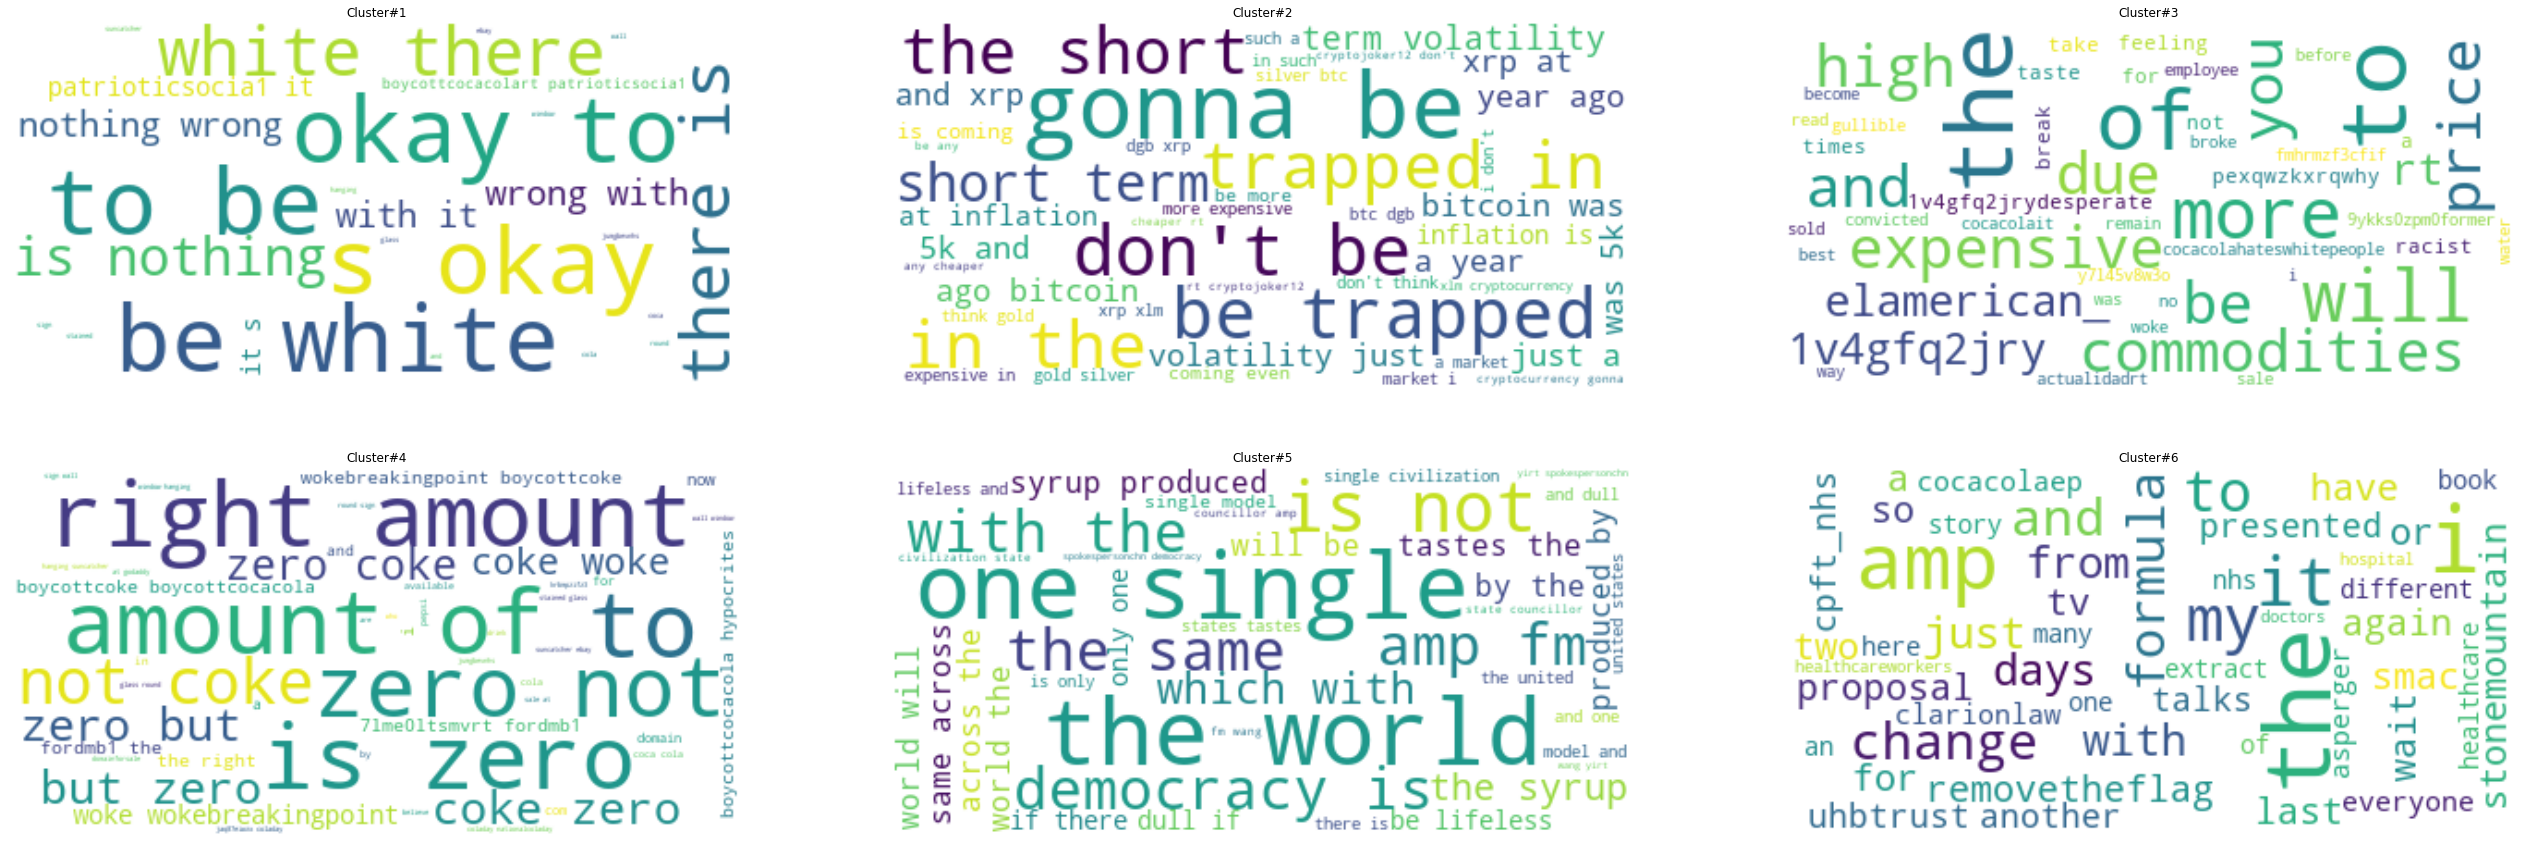

In [26]:
fix,ax=plt.subplots(nrows=2,ncols=3,figsize=(45,15))
#result=pd.DataFrame({'Cluster':clusters,'Tweets':tweetList})
for k in clusters:
    #print(k)
    text=''
    for l in clusters[k]:
        #print(l)
        #text = []
        text+=tweets_dict[l]
    text=text.lower()
    text=' '.join([word for word in re.split(r"[-;,\s]\s*",text) \
#                  if word not in ['delta','deltaairlines','#delta','@delta','@deltaairlines','https','t','co'] and len(word) > 3 
                  ])

    #print(text)
    #smallwords = [word for word in text.split() if len(word) < 4] 
    #print("smallwords", smallwords)
    exclude = ['delta','deltaairlines','#delta','@delta','@deltaairlines','https','t','co','that','cocacola']
    wordcloud = WordCloud(stopwords=exclude,max_font_size=50, max_words=50,background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    #print('Tweets')
    #tweets=tweets_dict[tweetClusters.cluster==k]['tweet']         
    #print(tweets.to_string(index=False))
    plt.subplot(2,3,k+1).title.set_text("Cluster#{}".format(k+1))
    #plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    #plt.show()